# Finetuning SubuGPT
### 1. Importing Instruction files
- Import your instruction file satisfying the following conditions:
  1. Must be `.json` file
  2. Each entry in instruction file must have instruction,input(optional) and output.
- Here we are importing the instruction file `Dataset/instruction-data.json` from the repository https://github.com/SubuMangu/SubuGPT as an example.

In [ ]:
import json
import os
import urllib


def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data

## Importing instruction dataset
file_path = "instruction-data.json"
url = "https://raw.githubusercontent.com/SubuMangu/SubuGPT/refs/heads/main/Dataset/instruction-data.json"

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


- To import a file from github:
  1. Click on `Raw` in top right corner region

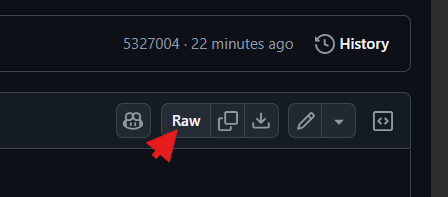

  2. Copy url

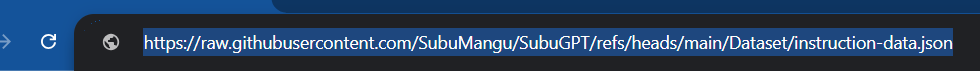

3. Use the url to retrieve the file using `urllib.request.urlretrieve(url, file_path)` as shown below.
- We are importing neccessary files like `GPTModules.py` and `gpt_download.py`

In [ ]:
# Importing neccesary GPT Modules
if not os.path.exists("GPTModules.py"):
    url = ("https://raw.githubusercontent.com/SubuMangu/SubuGPT/refs/heads/main/GPTModules.py")
    file_path = "GPTModules.py"
    urllib.request.urlretrieve(url, file_path)
# Importing files to  download gpt models from openai
if not os.path.exists("gpt_download.py"):
    url = ("https://raw.githubusercontent.com/SubuMangu/SubuGPT/refs/heads/main/gpt_download.py")
    file_path = "gpt_download.py"
    urllib.request.urlretrieve(url, file_path)


### 2. Formating entries

In [ ]:
def format_input(entry):
  # Can change the name of the keys in entry in the function match the component name of each entry
  # Don't change this format of instruction
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [ ]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


### 3. Creating Instruction Dataset

In [ ]:
!pip install tiktoken
import torch
import tiktoken
from GPTModules import InstructionDataset,custom_collate_fn
from GPTModules import generate,text_to_token_ids,token_ids_to_text

In [ ]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [ ]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

In [ ]:
from torch.utils.data import DataLoader
tokenizer = tiktoken.get_encoding("gpt2")

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

In [ ]:
val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

### 3. Loading pretrained weights to the

In [ ]:
config={
    'vocab_size': 50257,
    'context_length': 1024,
    'drop_rate': 0.0,
    'qkv_bias': True,
    'dim': 1024,
    'num_layers': 24,
    'num_heads': 16
    }

In [ ]:
from GPTModules import GPTModel
model=GPTModel(config)
model.load_state_dict(torch.load("model.pth", weights_only=True))
model.eval();
model.to(device)

In [ ]:
torch.manual_seed(123)

input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [ ]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

### 4. Finetune the model
- Download the `model.pth` file from https://huggingface.co/subumangu2003/subugpt

In [ ]:
from GPTModules import train_model

In [ ]:
import time

start_time = time.time()
num_epochs = 5
train_losses,val_losses,epochs=train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs,
    start_text=format_input(val_data[0]),
    tokenizer=tokenizer,
    new_tokens=50,
    learning_rate=0.00005,
    device=device
)
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Epoch 1: Train loss 0.47921043634414673, Val loss 0.6445431113243103
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Response:
Anna saves the day each night - saving Doyle from his hazardous meal.
Epoch 2: Train loss 0.3248623013496399, Val loss 0.6275027394294739
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Response:
The chef ensures each meal is cooked appropriately and healthfully.
Epoch 3: Train loss 0.23804201185703278, Val loss 0.6331682205200195
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Response:
The meal

### 5. Download the instruction with reponse data

In [ ]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    test_data[i]["model_response"] = response_text


with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)  # "indent" for pretty-printing

100%|██████████| 110/110 [01:27<00:00,  1.26it/s]


### 6. Save and Download the model

In [ ]:
torch.save(model.state_dict(), "model.pth")

In [ ]:
from google.colab import  files
files.download("model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>